In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
from tqdm import tnrange, tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import missingno as msno
import pickle
import swifter
import joblib

from scipy import spatial

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler(feature_range=[0, 1])

from sklearn.model_selection import train_test_split

import ml_metrics as metrics

np.random.seed(8418)

In [2]:
# helper functions

def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print('Elapsed time is ' + str(time.time() - startTime_for_tictoc) + ' seconds.')
    else:
        print('Toc: start time not set')
        
# confusion matrix plotting function
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# roc plot function

from sklearn.metrics import roc_curve, auc

def plot_roc_auc(actual, preds):
    fpr, tpr, thresholds = roc_curve(actual, preds[:,1])
    plt.plot(fpr, tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC: {}'.format(auc(fpr,tpr)))
    plt.show()

In [3]:
dat = pd.read_csv('../data/train_dask_subset.lzma', compression='xz')
#dest_dat = pd.read_csv('../data/destinations.csv')

del dat['is_booking']
dat = dat.iloc[:,1:]

KeyboardInterrupt: 

In [ ]:
dat.shape

In [ ]:
dat.head()

## Feature engineering

In [ ]:
# convert to datetime format and sort on date
dat['date_time'] = pd.to_datetime(dat['date_time'])
dat = dat.sort_values(by=['date_time'])

In [ ]:
dat['year'] = dat['date_time'].dt.year
dat['month'] = dat['date_time'].dt.month
dat['day'] = dat['date_time'].dt.day
dat['hour'] = dat['date_time'].dt.hour

dat['srch_ci'] = pd.to_datetime(dat['srch_ci'])
dat['srch_co'] = pd.to_datetime(dat['srch_co'])

dat['srch_ci_year'] = dat['srch_ci'].dt.year
dat['srch_ci_month'] = dat['srch_ci'].dt.month
dat['srch_ci_day'] = dat['srch_ci'].dt.day

dat['srch_co_year'] = dat['srch_co'].dt.year
dat['srch_co_month'] = dat['srch_co'].dt.month
dat['srch_co_day'] = dat['srch_co'].dt.day

dat['duration'] = (dat['srch_co'] - dat['srch_ci']).astype('timedelta64[D]')
dat['no_of_days_bet_booking'] = (dat['srch_ci'] - dat['date_time']).astype('timedelta64[D]')

del dat['srch_ci']
del dat['srch_co']
del dat['date_time']

In [ ]:
#dat = dat[dat['duration'] > 0] #2 entries have negative durations - ci < co

In [ ]:
dat.head()

#### Check for missing data

In [ ]:
 msno.matrix(dat.sample(250));

In [ ]:
# Just as a quick fix, I will fill in the missing values with mean for users in that hotel cluster
dat['orig_destination_distance'] = dat['orig_destination_distance'].fillna(dat.groupby('hotel_cluster')['orig_destination_distance'].transform('mean'))

In [ ]:
msno.matrix(dat.sample(250));

In [ ]:
dat['U']=dat.iloc[:,2:6].swifter.apply(lambda x: x.dropna().tolist(), axis=1)

In [98]:
dat['H']=dat.iloc[:,16:20].swifter.apply(lambda x: x.dropna().tolist(), axis=1)

/home/stephen/minimamba/lib/python3.7/site-packages/tqdm/std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [155]:
dist = []

for i in range(0,len(dat)):
    tmp = cdist(np.array(dat['U'][i]).reshape(1,-1), np.array(dat['H'][i]).reshape(1,-1), 'cosine')
    dist.append(tmp[0][0])

In [156]:
dat['cos_dist'] = dist

In [157]:
dat.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,day,hour,srch_ci_year,srch_ci_month,srch_ci_day,srch_co_year,srch_co_month,srch_co_day,duration,no_of_days_bet_booking,U,H,cos_dist
274226,2.0,3.0,66.0,442.0,19744.0,5315.4141,1173504.0,0.0,0.0,9.0,1.0,1.0,1.0,8739.0,1.0,1.0,6.0,144.0,4.0,2.0,2013.0,1.0,7.0,0.0,2013.0,1.0,20.0,2013.0,1.0,26.0,6.0,12.0,"[66.0, 442.0, 19744.0, 5315.4141]","[6.0, 144.0, 4.0, 2.0]",0.003586
1299880,34.0,3.0,205.0,155.0,41977.0,155.8350,725753.0,0.0,0.0,5.0,2.0,0.0,1.0,8288.0,1.0,1.0,2.0,198.0,399.0,10.0,2013.0,1.0,7.0,0.0,2013.0,1.0,11.0,2013.0,1.0,12.0,1.0,3.0,"[205.0, 155.0, 41977.0, 155.835]","[2.0, 198.0, 399.0, 10.0]",0.031854
817208,34.0,3.0,205.0,135.0,13892.0,118.0871,799663.0,0.0,0.0,5.0,3.0,1.0,1.0,25946.0,6.0,1.0,2.0,198.0,370.0,73.0,2013.0,1.0,7.0,0.0,2013.0,1.0,8.0,2013.0,1.0,10.0,2.0,0.0,"[205.0, 135.0, 13892.0, 118.0871]","[2.0, 198.0, 370.0, 73.0]",0.288348
967357,2.0,3.0,66.0,356.0,4779.0,4948.1861,593375.0,0.0,0.0,9.0,2.0,0.0,1.0,2763.0,3.0,2.0,6.0,70.0,1901.0,2.0,2013.0,1.0,7.0,0.0,2013.0,5.0,9.0,2013.0,5.0,10.0,1.0,121.0,"[66.0, 356.0, 4779.0, 4948.1861]","[6.0, 70.0, 1901.0, 2.0]",0.558267
2395829,2.0,3.0,66.0,467.0,16159.0,1510.8714,103449.0,0.0,1.0,9.0,2.0,0.0,1.0,8791.0,1.0,1.0,4.0,8.0,110.0,65.0,2013.0,1.0,7.0,0.0,2013.0,3.0,1.0,2013.0,3.0,5.0,4.0,52.0,"[66.0, 467.0, 16159.0, 1510.8714]","[4.0, 8.0, 110.0, 65.0]",0.005115


In [158]:
joblib.dump(dat, '../data/dat_final.joblib')

['../data/dat_final.joblib']

## Exploratory Data Analysis

In [5]:
y_dat = dat['hotel_cluster']

In [6]:
x_dat = dat.loc[:, ~dat.columns.isin(['hotel_cluster'])]

In [35]:
x_dat_scaled = StandardScaler().fit_transform(x_dat.iloc[:,1:-4])
scaler.fit(x_dat_scaled)
x_dat_scaled = scaler.transform(x_dat_scaled)

NameError: name 'StandardScaler' is not defined

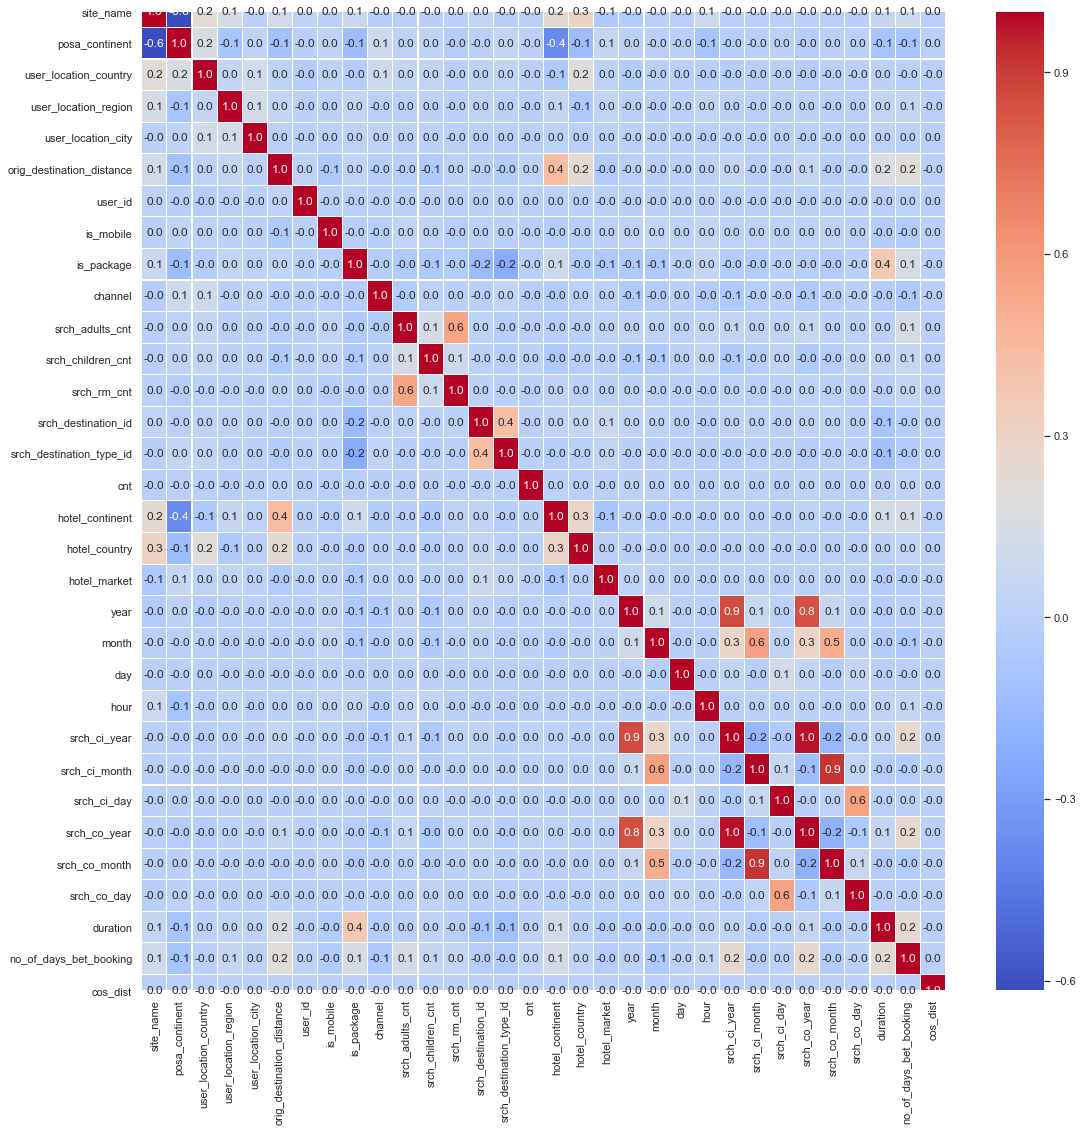

In [167]:
# heat map to look for correlation
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x_dat.corr(), cmap='coolwarm', annot=True, linewidths=.1, fmt= '.1f',ax=ax);

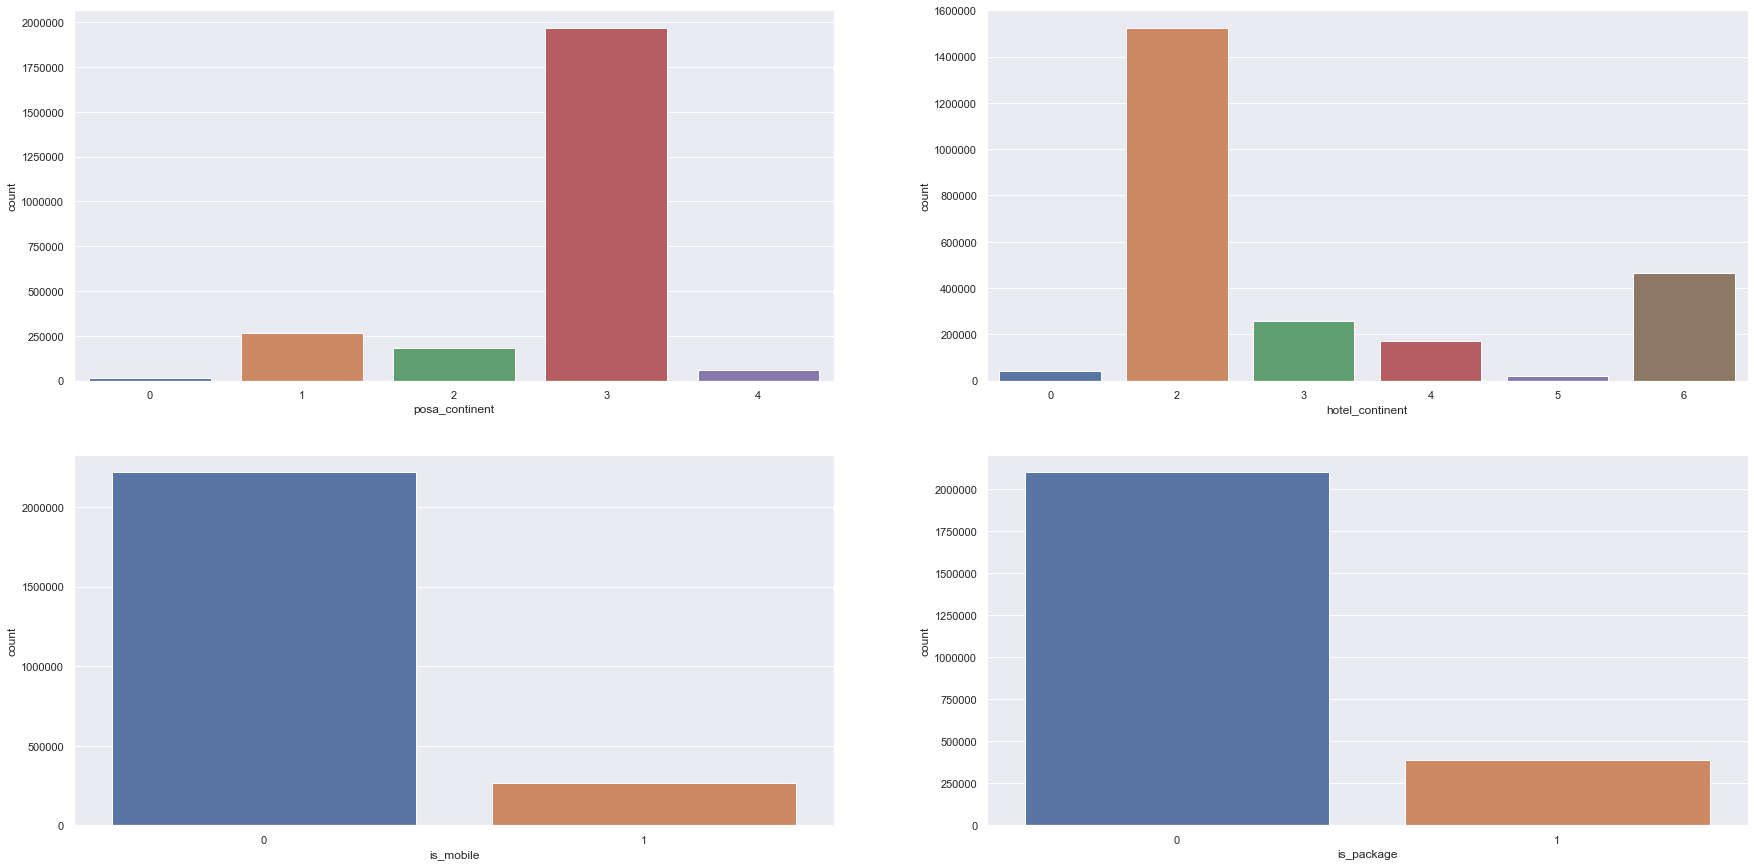

In [17]:
fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(30, 15)
sns.countplot('posa_continent', data=x_dat,order=[0,1,2,3,4],ax=axs[0,0])
sns.countplot('hotel_continent', data=x_dat,order=[0,2,3,4,5,6],ax=axs[0,1])
sns.countplot(x='is_mobile',data=x_dat, order=[0,1],ax=axs[1,0])
sns.countplot(x='is_package',data=x_dat, order=[0,1], ax=axs[1,1]);


/home/stephen/minimamba/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/stephen/minimamba/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


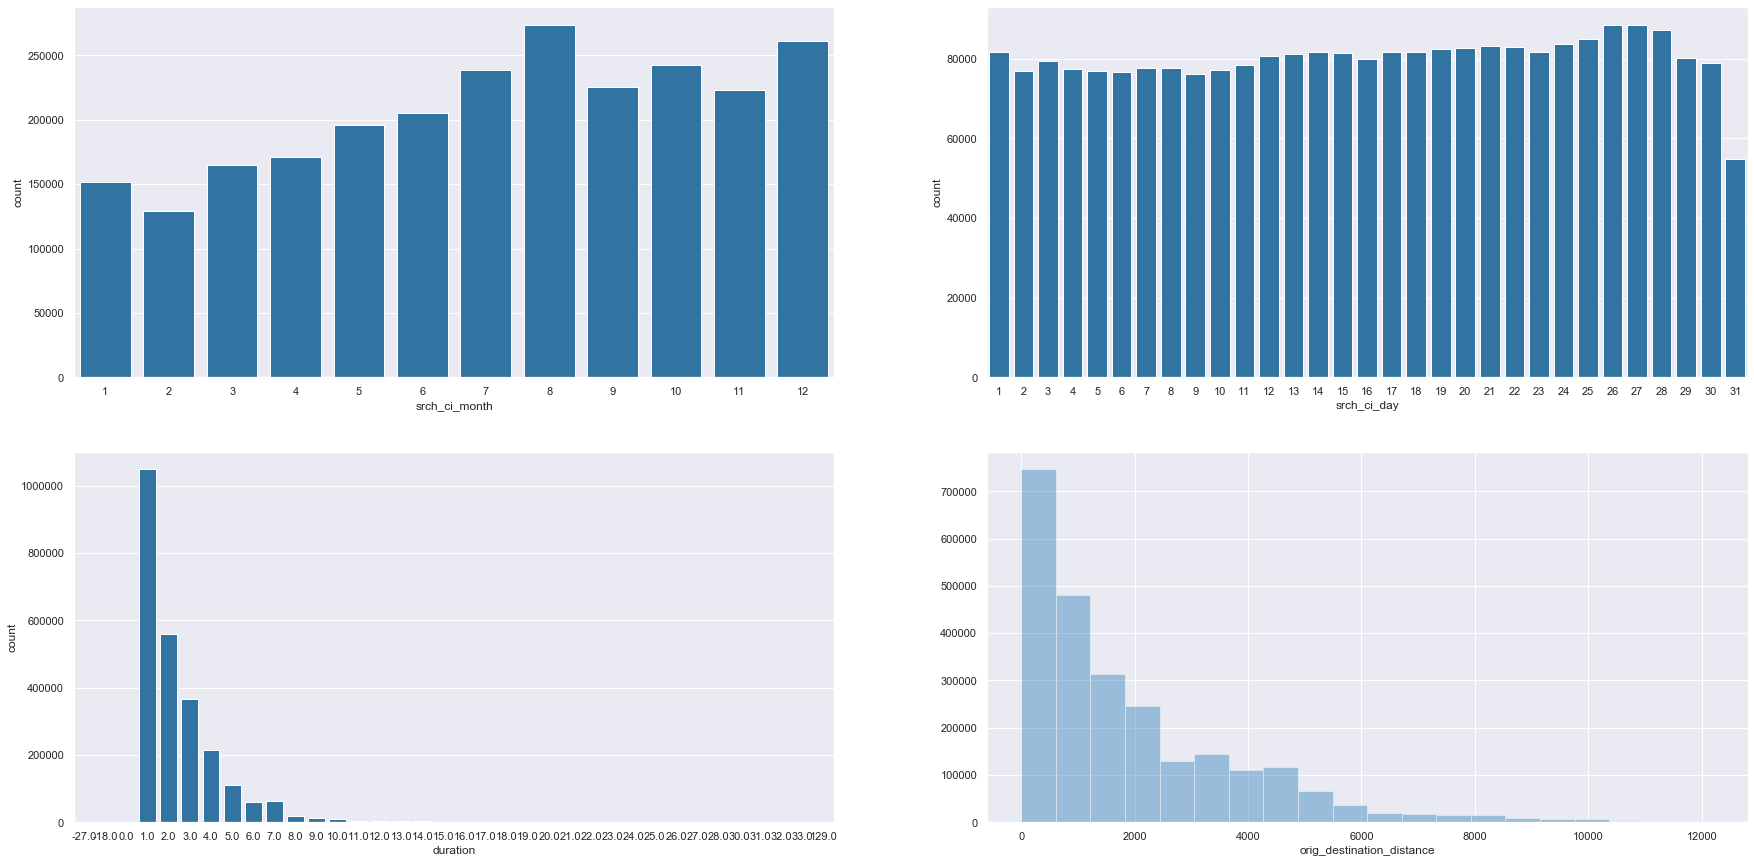

In [18]:
# Count the bookings in each month
fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(30, 15)
sns.countplot(x_dat['srch_ci_month'], order=list(range(1,13)), color='tab:blue', ax=axs[0,0])
sns.countplot(x_dat['srch_ci_day'], order=list(range(1,32)), color='tab:blue', ax=axs[0,1])
sns.countplot(x_dat['duration'],data=x_dat, color='tab:blue', ax=axs[1,0])
sns.distplot(x_dat['orig_destination_distance'], bins=20, kde=False, color='tab:blue', ax=axs[1,1]);

___

## Modeling

In [1]:
import lightgbm as lgb
import joblib
import numpy as np
import ml_metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler(feature_range=[0, 1])

In [2]:
dat = joblib.load('../data/dat_final.joblib')

x_dat = dat.loc[:, ~dat.columns.isin(['hotel_cluster'])]
y_dat = dat['hotel_cluster']
del x_dat['U']
del x_dat['H']

del dat

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(x_dat, y_dat, test_size=0.3, random_state=8418)
train_data=lgb.Dataset(xtrain,label=ytrain)

In [5]:
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class':100,
    'learning_rate': 0.05,
    'max_depth': 7,
    'num_leaves': 70,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 17,
    'min_split_gain': 0
    }

lgb_cv = lgb.cv(params, train_data, num_boost_round=1000, nfold=5, shuffle=True, stratified=True, verbose_eval=20, early_stopping_rounds=10)


[20]	cv_agg's multi_logloss: 3.04325 + 0.00179907
[40]	cv_agg's multi_logloss: 2.72671 + 0.00238848
[60]	cv_agg's multi_logloss: 2.55679 + 0.00267814
[80]	cv_agg's multi_logloss: 2.45611 + 0.0027644
[100]	cv_agg's multi_logloss: 2.38847 + 0.00235615
[120]	cv_agg's multi_logloss: 2.34556 + 0.00413133
[140]	cv_agg's multi_logloss: 2.31967 + 0.0142507


In [6]:
nround = lgb_cv['multi_logloss-mean'].index(np.min(lgb_cv['multi_logloss-mean']))
print(nround)

143


In [7]:
model = lgb.train(params, train_data, num_boost_round=nround)

In [8]:
filename = '../models/lgbmodel.joblib'

In [9]:
joblib.dump(model, filename)

['../models/lgbmodel.joblib']

In [10]:
joblib.load(filename)

In [11]:
ypred=model.predict(xtest)

In [12]:
# convert the array of probabilities for each class output by LightGBM into a single list 
# containing the class with the highest probability.

predictions = []

for x in ypred:
    predictions.append(np.argmax(x))

In [13]:
accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 42.73%
Recall: 42.726118206788044 %
Precision: 42.726118206788044 %


In [14]:
# retrieve top 5 predictions
best_n = np.argsort(ypred, axis=1)[:,-5:]

In [15]:
best_n[0]

array([42, 47, 18, 48, 91])

In [16]:
metrics.apk([ytest.iloc[2]], best_n[2], 5)

0.0

In [17]:
map5 = []
for i in range(0,len(ytest)):
    map5.append(metrics.apk([ytest.iloc[i]], best_n[i], 5))


In [18]:
np.mean(map5)

0.18076192982126418

In [19]:
np.std(map5)

0.20657170713276465

___

## Model Testing

Process the validation data provided by kaggle to present to the model

In [3]:
# load validation data provided on Kaggle.
dat = pd.read_csv('../data/test.csv.zip', compression='zip')

In [4]:
dat.shape #2528243

(2528243, 22)

In [ ]:
# convert to datetime format and sort on date
dat['date_time'] = pd.to_datetime(dat['date_time'])
dat = dat.sort_values(by=['date_time'])

In [ ]:
dat['year'] = dat['date_time'].dt.year
dat['month'] = dat['date_time'].dt.month
dat['day'] = dat['date_time'].dt.day
dat['hour'] = dat['date_time'].dt.hour

dat['srch_ci'] = pd.to_datetime(dat['srch_ci'], format='%Y-%m-%d', errors='coerce')
dat['srch_co'] = pd.to_datetime(dat['srch_co'], format='%Y-%m-%d', errors='coerce')

dat['srch_ci_year'] = dat['srch_ci'].dt.year
dat['srch_ci_month'] = dat['srch_ci'].dt.month
dat['srch_ci_day'] = dat['srch_ci'].dt.day

dat['srch_co_year'] = dat['srch_co'].dt.year
dat['srch_co_month'] = dat['srch_co'].dt.month
dat['srch_co_day'] = dat['srch_co'].dt.day

dat['duration'] = (dat['srch_co'] - dat['srch_ci']).astype('timedelta64[D]')
dat['no_of_days_bet_booking'] = (dat['srch_ci'] - dat['date_time']).astype('timedelta64[D]')

del dat['srch_ci']
del dat['srch_co']
del dat['date_time']

#dat = dat[dat['duration'] > 0]

In [ ]:
dat['orig_destination_distance'] = dat['orig_destination_distance'].fillna(dat.groupby('hotel_cluster')['orig_destination_distance'].transform('mean'))

In [ ]:
dat.head()

In [ ]:
dat.shape #2528243

In [ ]:
model = joblib.load('../models/lgbmodel.joblib')
ypred=model.predict(dat)

In [ ]:
joblib.dump(ypred, '../data/submission_predictions.joblib')
#ypred = joblib.load('../data/submission_predictions.joblib')

In [ ]:
best_n = np.argsort(ypred, axis=1)[:,-5:]

In [ ]:
# condense 5 columns from above into 1, space separated column for submission.
tmp = pd.DataFrame(best_n)
tmp['foo'] = tmp[tmp.columns[1:]].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1
)

In [ ]:
submission_dat = pd.DataFrame()
submission_dat['id'] = dat['id']
submission_dat['hotel_cluster'] = tmp['foo']

In [ ]:
submission_dat.head()

In [ ]:
len(submission_dat) #2528243

In [ ]:
pd.DataFrame.to_csv(submission_dat, '../data/submission_dat.csv', index=False)

The LightGBM model is terrible! (4% score in Kaggle!)

___